## Lasso Final VIF

Iteratively removed highly multicolinear features. This was done by looking at both VIF and coefficient. If a feature had a high VIF I would check what other features it was highly correlated with in a correlation matrix. The strategy was to try to remove features that Lasso did not find importnat but were highly correlated to other features that the model had selected. 

For example 'overall_score_square_root', 'overall_score', 'overall_score_squared', 'overall_score_cubed' were all high correlated with each other and caused a very high VIF for all four features. The model consistently selected 'overall_score_square_root' feature above the others so I removed the other three ('overall_score', 'overall_score_squared', 'overall_score_cubed'). Iteratively making similiar decisions helped improve the r2 score from 0.9209 to 0.9250.

In [1]:
# load packages
import pandas as pd
import numpy as np
import helper
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# see more rows of dataframe
pd.set_option('display.max_rows', 150)

In [3]:
# importing data
housing = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0,low_memory = False)
# data processing
train, test = helper.data_processing_wrapper(housing,
                                               num_to_cat_list = ['MSSubClass','MoSold'],
                                             remove_PID = False
                                        )

# feature engineering wrapper
train, test = helper.feature_engineering_wrapper(train, test)

# importing school feature
schools = pd.read_csv('schoolFeatures.csv',index_col = 0)
school_keep = [
    'PID',
    'closestSchool'
]
schools = schools[school_keep]

# merge school feature onto original data set.
train = train.merge(schools, how = 'left', left_on = 'PID', right_on = 'PID')
test = test.merge(schools, how = 'left', left_on = 'PID', right_on = 'PID')

train = train.dropna(subset=['closestSchool'])
train = train.reset_index(drop=True)

test = test.dropna(subset=['closestSchool'])
test = test.reset_index(drop=True)

In [4]:
# Features removed for having a high VIF
drop_col_list = ['PID','SalePrice',
                 'total_sf', 'total_sf_squared','total_sf_cubed',
                 'GrLivArea', 'GrLivArea_squared', 'GrLivArea_cubed',
                 'FullBath', 'BsmtHalfBath',
                 '1stFlrSF', 'TotalBsmtSF', 'BsmtUnfSF',
                 'overall_score', 'overall_score_squared', 'overall_score_cubed',
                 'GarageYrBlt','WoodDeckSF',
                 'year_since_built','year_since_built_squared', 'year_since_built_cubed',
                 'KitchenQual_square_root', 'KitchenQual',
                 'year_since_remod', 'year_since_remod_squared', 'year_since_remod_cubed',
                 'OverallQual', 'OverallQual_square_root','OverallQual_squared',
                 'LotArea', 'LotFrontage', 'LotArea_squared', 'LotArea_cubed',
                 'YearBuilt', 'YrSold', 'YearRemodAdd',
                 'BsmtExposure_squared', 'BsmtExposure','BsmtExposure_square_root', 'BsmtCond',
                 'GarageArea_square_root', 'GarageArea_squared', 'GarageArea', 
                 'ExterCond','GarageQual', 'GarageCars', 'GarageCond',
                 'KitchenQual_squared','Street', 'LandSlope',
                 'bsmt_score', 'exter_score','TotRmsAbvGrd',
                 'total_sf_square_root', 'total_high_qual_finished_sf',
                 'OverallQual_cubed', 'OverallCond','2ndFlrSF','HalfBath',
                 'GarageFinish', 'ExterQual', 'Alley', 'BedroomAbvGr',
                 'total_full_bath', 'year_since_remod_square_root', 'year_since_garage',
                 'FireplaceQu', 'KitchenAbvGr', 'BsmtQual', 'PavedDrive',
                 'garage_score', 'total_half_bath',
                 'LotShape', 'Utilities', 'BldgType', 'Exterior2nd',
                 'BsmtFinType2', 'Fence', 'SaleCondition',
                 'BldgType_log_comp', 'Neighborhood_log_comp', 'Condition1_log_comp'

                ]

#### train model

In [5]:
X = train.drop(drop_col_list,axis=1)
cat_feats = X.select_dtypes(['object','bool']).columns.to_list()
num_cols = X.select_dtypes(['float64','int64']).columns.to_list()

clf, transformer, scaler, clf_old = helper.lasso_grid_cv(train, cat_feats,
                  starting_alphas_= [0.0001, 0.0003, 0.0006, 0.001, 
                                    0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                    0.3, 0.6, 1],
                  n_jobs_ = -1,
                  cv_ = 5,
                     drop_cols_ = drop_col_list
                                           )

Performing Grid Search with alphas of: [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]
Current best alpha: 0.0006
Current best CV R2: 0.9442657516868247
Performing Grid Search with alphas of: [0.00018 0.00024 0.0003  0.00036 0.00042 0.00048 0.00054 0.0006  0.00066
 0.00072 0.00078 0.00084 0.0009  0.00096 0.00102 0.00108 0.00114]
Current best alpha: 0.00066
Current best CV R2: 0.9442804706059069
Performing Grid Search with alphas of: [0.000198 0.000264 0.00033  0.000396 0.000462 0.000528 0.000594 0.00066
 0.000726 0.000792 0.000858 0.000924 0.00099  0.001056 0.001122 0.001188
 0.001254]
Current best alpha: 0.00066
Current best CV R2: 0.9442804706059069
Modeling complete :)


#### model test scores

In [6]:
# compute r2 score
X_tst = test.drop(drop_col_list,axis=1)
X_tst = transformer.transform(X_tst)
X_tst = scaler.transform(X_tst)
y_tst = np.log(test['SalePrice'])

clf.score(X_tst,y_tst)

0.9250038072268814

In [7]:
# compute rmse score
y_pred_tst = clf.predict(X_tst)

rms = mean_squared_error(y_tst, y_pred_tst, squared=False)
rms

0.10258084307911293

#### coeffiecient dataframe

In [8]:
# set up the columns to have feature names be interpretable
columns_transformed = transformer.named_transformers_['Cat'].get_feature_names(input_features= cat_feats)
new_columns = list(columns_transformed)+num_cols
# construct dataframe
coef_df = pd.DataFrame({'features':new_columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True).reset_index()
coef_df.columns = ['coefs_rank', 'features', 'coefs', 'coefs_abs']
coef_df

,coefs_rank,features,coefs,coefs_abs
0,0,GrLivArea_square_root,1.558940e-01,1.558940e-01
1,1,year_since_built_square_root,-9.765204e-02,9.765204e-02
2,2,overall_score_square_root,7.558475e-02,7.558475e-02
3,3,LotArea_square_root,3.192828e-02,3.192828e-02
4,4,BsmtFinSF1,3.150340e-02,3.150340e-02
...,...,...,...,...
149,149,Exterior1st_Wd Sdng,-1.407151e-04,1.407151e-04
150,150,HouseStyle_2.5Fin,9.330910e-05,9.330910e-05
151,151,Condition2_PosN,2.964905e-05,2.964905e-05
152,152,BsmtFinType1_Unf,-2.718772e-05,2.718772e-05


In [9]:
# prepare data for computing VIF
X = transformer.transform(X)
X = scaler.transform(X)

columns_transformed = transformer.named_transformers_['Cat'].get_feature_names(input_features= cat_feats)
new_columns = list(columns_transformed)+num_cols

df_train = pd.DataFrame.sparse.from_spmatrix(X, columns = new_columns)
df_train = df_train[num_cols]

# Computing VIF
vif_data = pd.DataFrame()
vif_data["features"] = df_train.columns
vif_data["VIF"] = [variance_inflation_factor(df_train.values, i)
                          for i in range(len(df_train.columns))]

# view features with highest VIF
vif_data = vif_data.sort_values('VIF',ascending=False).reset_index(drop=True)
vif_data.merge(coef_df,how='left',left_on='features',right_on='features')

,features,VIF,coefs_rank,coefs,coefs_abs
0,GarageCars_log_comp,3835.604159,5,0.026053,0.026053
1,MSZoning_log_comp,3586.919319,12,0.015192,0.015192
2,GrLivArea_square_root,83.543329,0,0.155894,0.155894
3,overall_score_square_root,73.313479,2,0.075585,0.075585
4,HeatingQC,28.916762,27,0.009290,0.009290
5,LotArea_square_root,19.086626,3,0.031928,0.031928
6,year_since_built_square_root,9.927370,1,-0.097652,0.097652
7,KitchenQual_cubed,8.142534,6,0.018870,0.018870
8,BsmtFinSF1,4.404839,4,0.031503,0.031503
9,total_deck_sf,4.333095,34,0.007925,0.007925


#### Check high VIF features for which other features they are correlated to

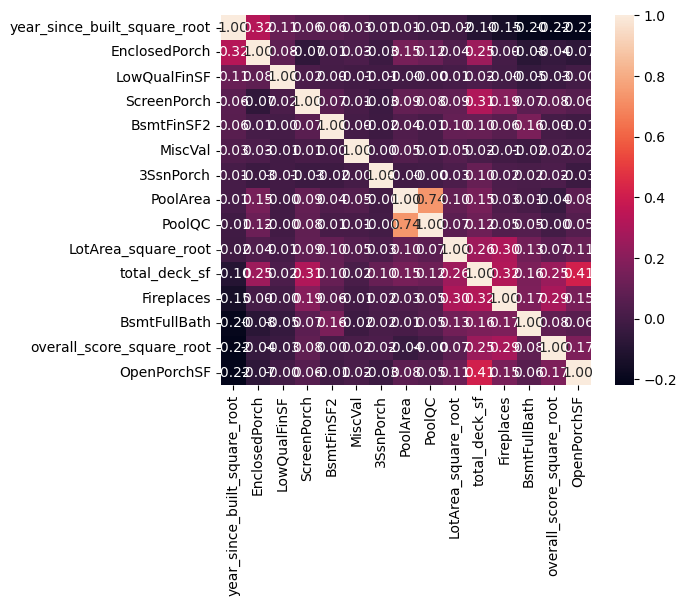

In [10]:
corr_feat_pick = 'year_since_built_square_root'

k = 15 #number of variables for heatmap
cols = df_train.corr().nlargest(k, corr_feat_pick)[corr_feat_pick].index
cm = np.corrcoef(train[cols].values.T)
# sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()